## <center>Mask Detection</center>

This file is of colab
1. Run this in colab
2. Upper Commands are aslo of colab 
3. Here we will train our model and save it
4. Then apply this in our part -2(Saved model)

In [ ]:
!wget https://www.techsimplus.com/media/Mask_noMask.zip

In [ ]:
!unzip Mask_noMask.zip

Now we are imoorting libraries

In [3]:
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Flatten,Dropout,Dense,Input
from tensorflow.keras.preprocessing.image import img_to_array,load_img,ImageDataGenerator
from tensorflow.keras.applications import VGG19
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
import os
import numpy as np


Creating path of images

In [6]:
image_path = []
for i in os.listdir("./dataset/"):
  for img in os.listdir("./dataset/"+i):
    path = "./dataset/"+i+"/"+img
    image_path.append(path)

In [7]:
image_path[:10]

['./dataset/without_mask/augmented_image_72.jpg',
 './dataset/without_mask/augmented_image_94.jpg',
 './dataset/without_mask/403.jpg',
 './dataset/without_mask/7.jpg',
 './dataset/without_mask/18.jpg',
 './dataset/without_mask/248.jpg',
 './dataset/without_mask/392.jpg',
 './dataset/without_mask/184.jpg',
 './dataset/without_mask/341.jpg',
 './dataset/without_mask/augmented_image_18.jpg']

Creating our labels and data

In [9]:
img_data = []
labels = []
for i in image_path:
  label = i.split("/")[-2]             #as we see our path at -2 we have mask and without mask so we will get that part by splitting and we will pass this in labelbinize
  img = load_img(i,target_size=(224,224))   #target size is 224,224 because we have VGG19 model which take 224,224 as input image
  img = img_to_array(img)
  img = preprocess_input(img)               #convert data into arrya of tensorflow floast-32
  img_data.append(img)
  labels.append(label)
img_data = np.array(img_data)
labels = np.array(labels)



In [16]:
labels[:10]

array(['without_mask', 'without_mask', 'without_mask', 'without_mask',
       'without_mask', 'without_mask', 'without_mask', 'without_mask',
       'without_mask', 'without_mask'], dtype='<U12')

In [11]:
label = LabelBinarizer()                              #calling LabelBinarizer 
Label = label.fit_transform(labels)                   #converting text(mask, no mask) into 0 and 1
Label = to_categorical(Label)                         #converting into [0,1],[1,0] format(Softmax layer)

In [15]:
Label[:10]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

Splitting Data

In [33]:
trainX,testX,trainY,testY = train_test_split(img_data,Label,test_size=.2)

Processing image generation 

In [18]:
#we will call this step in fit model part
img_generation = ImageDataGenerator(rotation_range=30,
                                    height_shift_range=.1,
                                    width_shift_range=.1,
                                    zoom_range=.2,
                                    horizontal_flip=True,
                                    fill_mode="nearest")

Calling pretrained model with removed output layers

In [20]:
baseModel = VGG19(include_top=False,input_tensor=Input(shape=(224,224,3)))

80142336/80134624 [==============================] - 1s 0us/step


In [24]:
headModel = baseModel.output
headModel = Flatten(name="MY_Add")(headModel)
headModel = Dense(300,activation="relu",name="My_Add_2")(headModel)
headModel = Dropout(.5)(headModel)

#output layer
headModel = Dense(2,activation="softmax",name="My_Add_3")(headModel)

#merting output and input layers
model = Model(inputs=baseModel.input,outputs=headModel)

In [26]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

Stopping layer to create new baits

In [27]:
for layer in baseModel.layers:
  layer.trainable = False

Compiling Model

In [31]:
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

Traning Data

In [34]:
his = model.fit(img_generation.flow(trainX,trainY,batch_size=40),epochs=5,validation_data=(testX,testY))

Epoch 1/5
28/28 [==============================] - 12s 417ms/step - loss: 1.6939 - accuracy: 0.9491 - val_loss: 1.7107 - val_accuracy: 0.9819
Epoch 2/5
28/28 [==============================] - 11s 386ms/step - loss: 0.6132 - accuracy: 0.9873 - val_loss: 0.3933 - val_accuracy: 0.9928
Epoch 3/5
28/28 [==============================] - 11s 386ms/step - loss: 0.9193 - accuracy: 0.9900 - val_loss: 0.6385 - val_accuracy: 0.9928
Epoch 4/5
28/28 [==============================] - 11s 388ms/step - loss: 0.5430 - accuracy: 0.9955 - val_loss: 1.1926 - val_accuracy: 0.9928
Epoch 5/5
28/28 [==============================] - 11s 388ms/step - loss: 1.2399 - accuracy: 0.9873 - val_loss: 0.8457 - val_accuracy: 0.9928


Ploting Graph

In [41]:
loss = his.history["loss"]
accuracy = his.history["accuracy"]
val_loss  = his.history["val_loss"]
val_accuracy  = his.history["val_accuracy"]

import pandas as pd
acc_df = pd.DataFrame({
    "acc":accuracy,
    "val_acc":val_accuracy
})

loss_df = pd.DataFrame({
    "loss":loss,
    "val_loss":val_loss
})

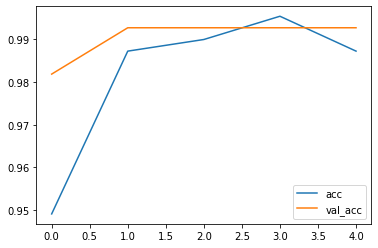

In [42]:
acc_df.plot()

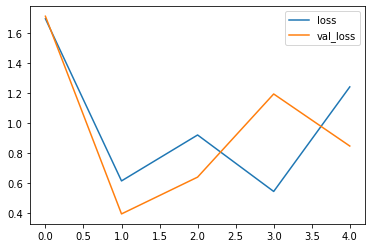

In [43]:
loss_df.plot()

Predecting Image 

In [56]:
img = load_img("kt.jpg",target_size=(224,224))
img = img_to_array(img)
img = np.expand_dims(img,axis=0)
img = preprocess_input(img)



In [57]:
model.predict(img)

array([[1., 0.]], dtype=float32)